<a href="https://colab.research.google.com/github/jacol/mAIa_fractals/blob/main/CUDA_Mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [ ]:
from numba import cuda
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
%matplotlib inline
import random as rnd

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/mAIa_partials'
results_dir = '/content/gdrive/My Drive/mAIa_results'

Mounted at /content/gdrive


## Base functions

In [26]:
def draw_image(mat, cmap='inferno', powern=0.5, dpi=72):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    full_file_name = f"{images_dir}/{timestr}.png"

    ## Value normalization
    # Apply power normalization, because number of iteration is 
    # distributed according to a power law (fewer pixels have 
    # higher iteration number)
    mat = np.power(mat, powern)
    
    # Colormap: set the color the black for values under vmin (inner points of
    # the set), vmin will be set in the imshow function
    new_cmap = copy.copy(cm.get_cmap(cmap))
    new_cmap.set_under('black')
    
    ## Plotting image        
    # Figure size
    plt.figure(figsize=(mat.shape[0]/dpi, mat.shape[1]/dpi))
    

    # Remove axis and margins
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')

    plt.savefig(full_file_name, bbox_inches='tight')

    entropy = calc_entropy(full_file_name)
    
    plt.text(10, 10, full_file_name + "(" + str(entropy) + ")", color="white", fontsize=18, bbox=dict(fill=True, edgecolor='red', linewidth=2))

    # Plotting mat with cmap
    # vmin=1 because smooth iteration count is always > 1
    # We need to transpose mat because images use row-major
    # ordering (C convention)
    # origin='lower' because mat[0,0] is the lower left pixel
    plt.imshow(mat.T, cmap=new_cmap, vmin=1, origin = 'lower')
    
    

    return full_file_name

@cuda.jit
def mandelbrot_gpu(mat, maxiter=100, xmin=-2.6, xmax=1.85, ymin=-1.25, ymax=1.25):
    x = cuda.blockIdx.x
    y = cuda.threadIdx.x
    
    # Mapping pixel to C
    creal = xmin + x / mat.shape[0] * (xmax - xmin)
    cim = ymin + y / mat.shape[1] * (ymax - ymin)
    
    # Initialisation of C and Z
    c = complex(creal, cim)
    z = complex(0, 0)    
    
    # Mandelbrot iteration
    for n in range(maxiter):
        z = z*z+c
        # If unbounded: save iteration count and break
        if z.real*z.real + z.imag*z.imag > 4.0:
            # Smooth iteration count
            mat[x,y] = n + 1 - math.log(math.log(abs(z*z+c)))/math.log(2)
            break
        # Otherwise: leave it to 0

def calc_entropy(filename):
  
  with open(filename, "rb") as file:
      counters = {byte: 0 for byte in range(2 ** 8)}  # start all counters with zeros

      for byte in file.read():  # read in chunks for large files
          counters[byte] += 1  # increase counter for specified byte

      filesize = file.tell()  # we can get file size by reading current position

      probabilities = [counter / filesize for counter in counters.values()]  # calculate probabilities for each byte

      entropy = -sum(probability * math.log2(probability) for probability in probabilities if probability > 0)  # final sum

      return entropy

## Default Mandelbrot

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


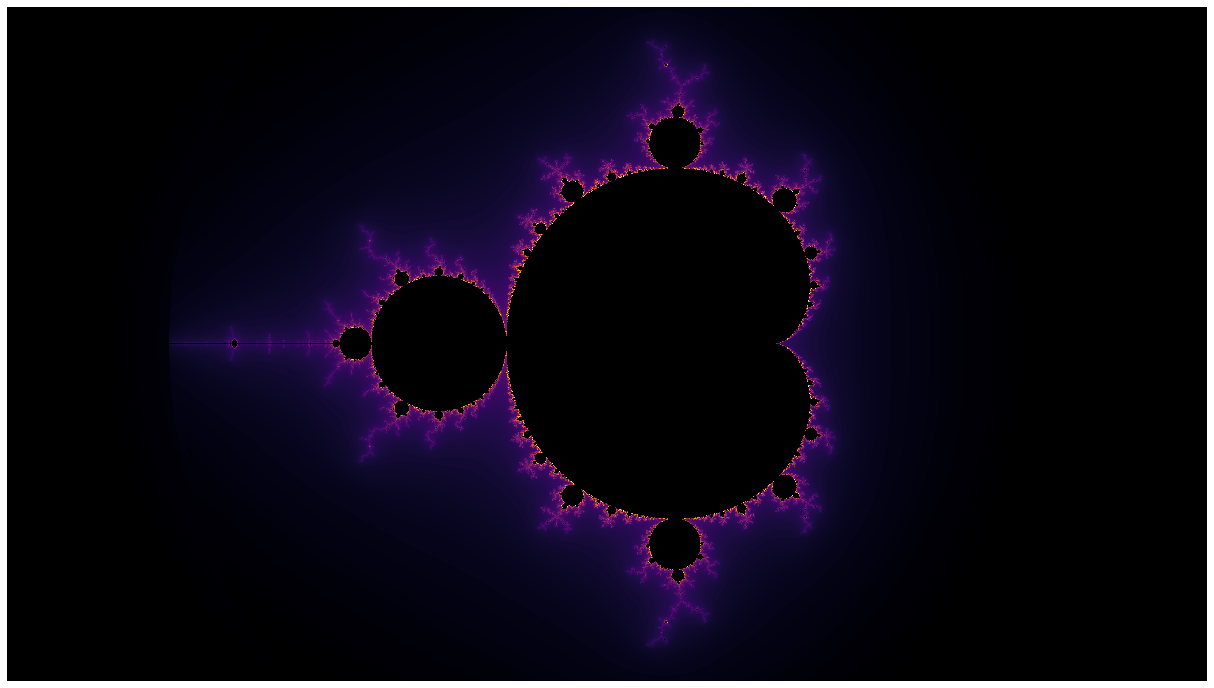

In [ ]:
# Parameters

xmin, xmax = -2.6, 1.85
ymin, ymax = -1.25, 1.25
xpixels = 1200
ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))
maxiter = 1000
mat = np.zeros((xpixels, ypixels))

# Running and plotting result
mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)
draw_image(mat, powern = .3)

## Deep dive

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


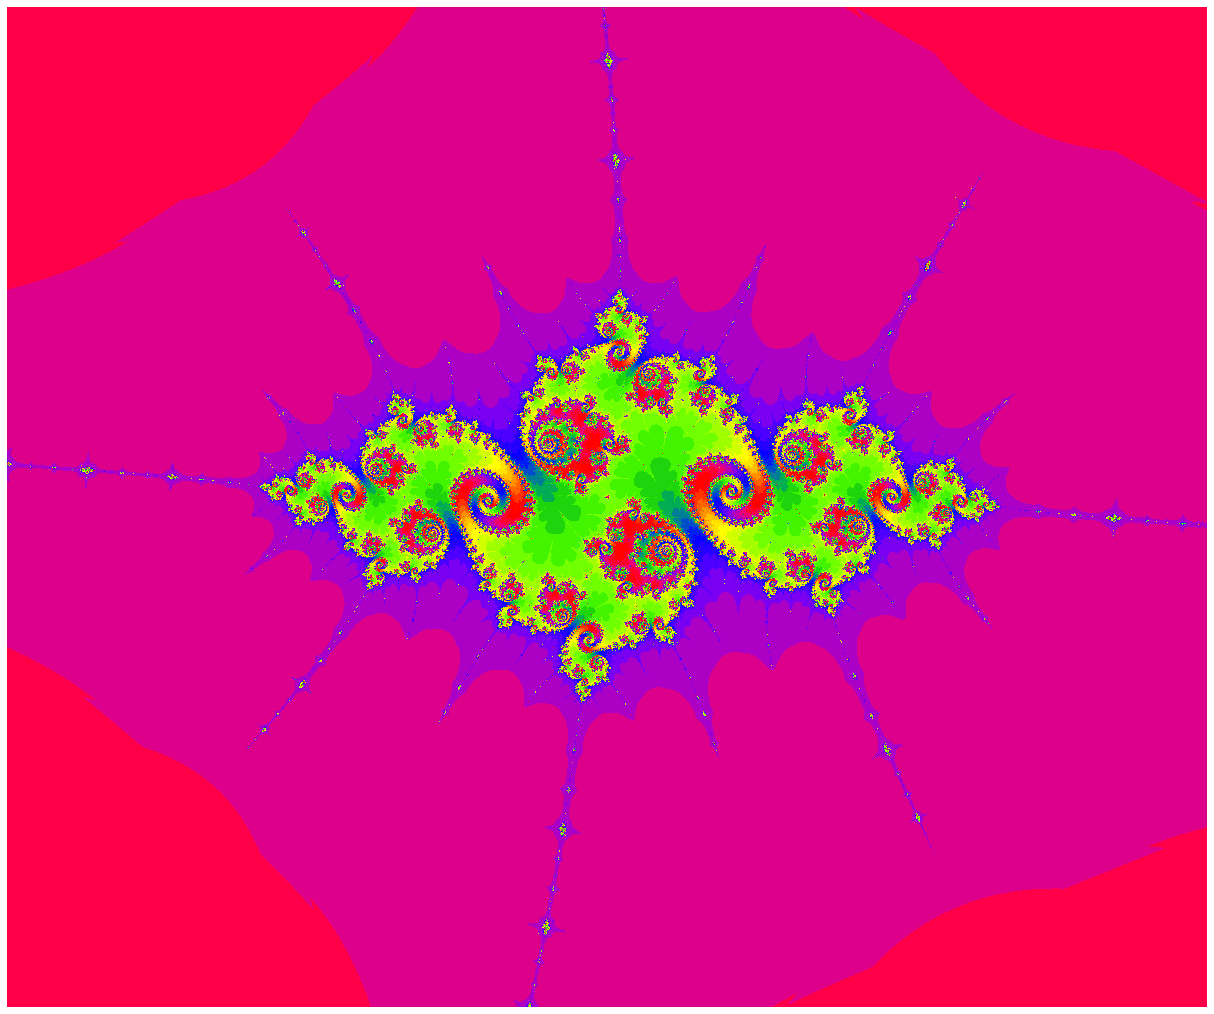

In [ ]:
xmin, xmax = -1.7687782, -1.7687794
ymin, ymax = -0.0017384, -0.0017394
xpixels = 1200
ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))
# Some deeper places need more iterations
maxiter = 1e4
mat = np.zeros((xpixels, ypixels))

mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)
draw_image(mat, cmap='prism_r', powern = 1)

## Depp dive #2

In [ ]:
xmin, xmax = -0.776606, -0.776581
ymin, ymax = -0.136651, -0.136630
xpixels = 1200
ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))
mat = np.zeros((xpixels, ypixels))
maxiter = 1e4

mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)
draw_image(mat, cmap='gist_stern', powern = .8)

In [ ]:
xmin, xmax = -0.3754, -0.3725
ymin, ymax = 0.6585, 0.6609
xpixels = 1200
ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))
mat = np.zeros((xpixels, ypixels))

mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)
draw_image(mat, cmap='gist_ncar')


## Custom implementation

In [21]:
def draw_cuda_mandel(cor, cmap_collection):
  xmin, xmax = cor[0], cor[1]
  ymin, ymax = cor[2], cor[3]

  xpixels = 1800
  ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))

  maxiter = 1e6

  mat = np.zeros((xpixels, ypixels))

  mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)

  for cmap in cmap_collection:
    file_name = draw_image(mat, cmap=cmap)
    

In [ ]:

coordinates = [
    (-1.287183264510, -1.287148053123, -0.056886263110, -0.056870832679),
    (-0.152225772795, -0.152209116057, -1.033059878973, -1.033053157477),
    (-0.152211063101, -0.152211063059, -1.033055704934, -1.033055704916),
    (-1.266974307353, -1.172492465857, -0.335655185723, -0.294251092067),
    (-1.185484224653, -1.185178885557, -0.305620990395, -0.305497776871),
    (-1.185183470145, -1.185182870435, -0.305553252222, -0.305552989415),
    (-1.185183196643, -1.185183121539, -0.305553142903, -0.305553109991),
    (-1.185183173041, -1.185183151449, -0.305553104748, -0.305553095286),
    (-1.185183165748, -1.185183165235, -0.305553102702, -0.305553102477),
    (-1.185183165513, -1.185183165500, -0.305553102611, -0.305553102605),
    (-1.448493512399, -1.448491426421, -0.016848168403, -0.016847326649),
    (-1.448492758109, -1.448492757331, -0.016847599488, -0.016847599147),
    (0.332978767532, 0.427460609027, -0.612938293755, -0.571534200099),
    (-0.752804147614, -0.751322354048, -0.038086605144, -0.037437249473)
]

for i in range(0, 15):
  cor = rnd.choice(coordinates)
  x_dif = ((cor[1] - cor[0]) / (i+3))
  y_dif = ((cor[3] - cor[2]) / (i+3))

  normalizer = 1
  if i%2 == 0:
    normalizer = 1
  else:
    normalized = -1

  new1 = cor[0] + x_dif * normalizer
  new2 = cor[1] + x_dif * normalizer
  new3 = cor[2] + y_dif * normalizer
  new4 = cor[3] + y_dif * normalizer
  cor = (new1, new2, new3, new4)

  # cmap = rnd.choice(plt.colormaps())  
  cmap = rnd.choice(['prism', 'prism_r', 'flag', 'flag_r', 'inferno', 'inferno_r', 'hot', 'hot_r', 'gist_rainbow', 'gist_rainbow_r'])  
  draw_cuda_mandel(cor, [cmap])

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
# Importing Image module from PIL package 
from PIL import Image

import os
from pathlib import Path

paths = sorted(Path(images_dir).iterdir(), key=os.path.getmtime)

single_w, single_h = 450, 185
rows, columns = 5, 3

result = Image.new('RGB',(columns * single_w, rows * single_h), (0,0,0))
counter, x, y = 0, 0, 0

for n in range(-1 * rows * columns, 0, 1):
  image = Image.open(paths[n])
  image = image.resize((single_w, single_h))
  
  if counter == 1:
    image = image.transpose(Image.FLIP_LEFT_RIGHT)
  elif counter == 2:
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

  result.paste(image, (x, y))
  counter+=1
  x+=single_w

  if counter == 3:
    x = 0
    y+=single_h
    counter = 0

timestr = time.strftime("%Y%m%d-%H%M%S")
result.save(f'{results_dir}/{timestr}.png')
